In [110]:
import pickle
import numpy as np
import glob
import pandas as pd
import torch
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [111]:
results_path = 'test_results.pkl'
image_detection_data_path = '../data/Potholes/Proposals_test/test_detection/*'

In [112]:
# result = [predicted, label, path]
with open(results_path, "rb") as f:
    results = pickle.load(f)

# list[pkl]
image_detection_data_list = glob.glob(image_detection_data_path)

In [113]:
results_df = pd.DataFrame(results, columns=['predicted', 'label', 'confidence', 'proposal_path'])

In [114]:
results_df['proposal_path'] = results_df['proposal_path'].apply(lambda x: x.split('/')[-1])

In [115]:
rows = []

for image_detection_data_pkl in image_detection_data_list:
    img_id = int(image_detection_data_pkl.split('-')[-1].split('_')[0])
    
    with open(image_detection_data_pkl, "rb") as f:
        image_detection_data = pickle.load(f)
    
    groundtruth = image_detection_data['groundtruth']
    proposals = image_detection_data['proposals']
    
    max_len = max(len(groundtruth), len(proposals))
    
    for i in range(max_len):
        gt = groundtruth[i] if i < len(groundtruth) else None
        prop = proposals[i] if i < len(proposals) else None
        rows.append({
            'img_id': img_id,
            'groundtruth': gt,
            'proposals': prop
        })

image_detection_df = pd.DataFrame(rows)

In [116]:
image_detection_df['proposals'] = image_detection_df['proposals'].apply(lambda x: x if x is not None else [None, None])

image_detection_df[['proposal_path', 'proposal_bbox']] = pd.DataFrame(
    image_detection_df['proposals'].tolist(),
    index=image_detection_df.index
)

image_detection_df.drop(columns='proposals', inplace=True)

In [117]:
def convert_groundtruth(x):
    if x is None:  # Handle None values
        return None
    return [val.item() if isinstance(val, torch.Tensor) else val for val in x]

image_detection_df['groundtruth'] = image_detection_df['groundtruth'].apply(convert_groundtruth)


In [118]:
# Merge the two DataFrames
merged_df = pd.merge(image_detection_df, results_df, on='proposal_path', how='inner')

In [119]:
merged_df.head(20)

,img_id,groundtruth,proposal_path,proposal_bbox,predicted,label,confidence
0,268,"[258.0, 195.0, 494.0, 414.0]",img-268_proposal_0.jpg,"[258, 191, 498, 407]",0.0,0,"[[0.9999882, 6.5435197e-06]]"
1,268,None,img-268_proposal_1.jpg,"[258, 199, 498, 406]",0.0,0,"[[0.99997747, 1.193293e-05]]"
2,268,None,img-268_proposal_2.jpg,"[258, 201, 498, 406]",0.0,0,"[[0.9999751, 1.3698315e-05]]"
3,268,None,img-268_proposal_3.jpg,"[252, 194, 502, 407]",0.0,0,"[[0.9999924, 3.8578933e-06]]"
4,268,None,img-268_proposal_4.jpg,"[252, 188, 502, 407]",0.0,0,"[[0.99998415, 8.343707e-06]]"
5,268,None,img-268_proposal_5.jpg,"[269, 201, 498, 406]",0.0,0,"[[0.99988914, 6.315207e-05]]"
6,268,None,img-268_proposal_6.jpg,"[274, 191, 498, 407]",0.0,0,"[[0.999902, 5.887057e-05]]"
7,268,None,img-268_proposal_7.jpg,"[252, 194, 486, 397]",0.0,0,"[[0.9998815, 6.22956e-05]]"
8,268,None,img-268_proposal_8.jpg,"[252, 175, 505, 407]",0.0,0,"[[0.99990904, 5.248684e-05]]"
9,268,None,img-268_proposal_9.jpg,"[231, 188, 502, 407]",0.0,0,"[[0.9998147, 0.00012393312]]"


In [120]:
merged_df['confidence'] = merged_df['confidence'].apply(lambda x: max(x[0]))

In [121]:
merged_df.head(20)

result_df_without_nms = merged_df.copy()


In [122]:
def calculate_iou(box1, box2):
        
    box1 = [int(x) for x in box1]
    box2 = [int(x) for x in box2]
    
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = box1_area + box2_area - intersection
    
    return intersection / union if union > 0 else 0

def apply_nms(df, iou_threshold=0.5, confidence_threshold=0.5):
    result_df = df.copy()
    
    for img_id in df['img_id'].unique():
        img_mask = result_df['img_id'] == img_id
        img_df = result_df[img_mask].copy()
        
        valid_mask = img_df['confidence'] >= confidence_threshold
        valid_indices = img_df[valid_mask].index
        
        if len(valid_indices) == 0:
            result_df.loc[img_mask, 'proposal_bbox'] = result_df.loc[img_mask, 'proposal_bbox'].apply(lambda x: [])
            continue
            
        sorted_indices = valid_indices[(-img_df.loc[valid_indices, 'confidence']).argsort()]
        
        kept_indices = []
        suppressed_indices = []
        
        for idx in sorted_indices:
            if idx in suppressed_indices:
                continue
                
            kept_indices.append(idx)
            current_box = result_df.loc[idx, 'proposal_bbox']
            
            for other_idx in sorted_indices:
                if other_idx == idx or other_idx in suppressed_indices:
                    continue
                    
                other_box = result_df.loc[other_idx, 'proposal_bbox']
                iou = calculate_iou(current_box, other_box)
                
                if iou > iou_threshold:
                    suppressed_indices.append(other_idx)
        
        # result_df.loc[suppressed_indices, 'proposal_bbox'] = result_df.loc[suppressed_indices, 'proposal_bbox'].apply(lambda x: [])
        
        # low_conf_indices = img_df[~valid_mask].index
        # result_df.loc[low_conf_indices, 'proposal_bbox'] = result_df.loc[low_conf_indices, 'proposal_bbox'].apply(lambda x: [])
        result_df.loc[suppressed_indices, 'proposal_bbox'] = None
        low_conf_indices = img_df[~valid_mask].index
        result_df.loc[low_conf_indices, 'proposal_bbox'] = None
    
    return result_df

def process_dataframe(merged_df, confidence_threshold=0.5):
    result_df = apply_nms(merged_df, confidence_threshold=confidence_threshold)
    
    return result_df

In [123]:
result_df = process_dataframe(merged_df)

In [124]:
result_df.head(40)

,img_id,groundtruth,proposal_path,proposal_bbox,predicted,label,confidence
0,268,"[258.0, 195.0, 494.0, 414.0]",img-268_proposal_0.jpg,None,0.0,0,0.999988
1,268,None,img-268_proposal_1.jpg,None,0.0,0,0.999977
2,268,None,img-268_proposal_2.jpg,None,0.0,0,0.999975
3,268,None,img-268_proposal_3.jpg,"[252, 194, 502, 407]",0.0,0,0.999992
4,268,None,img-268_proposal_4.jpg,None,0.0,0,0.999984
5,268,None,img-268_proposal_5.jpg,None,0.0,0,0.999889
6,268,None,img-268_proposal_6.jpg,None,0.0,0,0.999902
7,268,None,img-268_proposal_7.jpg,None,0.0,0,0.999882
8,268,None,img-268_proposal_8.jpg,None,0.0,0,0.999909
9,268,None,img-268_proposal_9.jpg,None,0.0,0,0.999815


In [128]:
# single image example

img_detection = result_df[result_df['img_id'] == 268]
img_detection_wihtout_nms = result_df_without_nms[result_df_without_nms['img_id'] == 268]
print(img_detection_wihtout_nms)

    img_id                   groundtruth            proposal_path  \
0      268  [258.0, 195.0, 494.0, 414.0]   img-268_proposal_0.jpg   
1      268                          None   img-268_proposal_1.jpg   
2      268                          None   img-268_proposal_2.jpg   
3      268                          None   img-268_proposal_3.jpg   
4      268                          None   img-268_proposal_4.jpg   
5      268                          None   img-268_proposal_5.jpg   
6      268                          None   img-268_proposal_6.jpg   
7      268                          None   img-268_proposal_7.jpg   
8      268                          None   img-268_proposal_8.jpg   
9      268                          None   img-268_proposal_9.jpg   
10     268                          None  img-268_proposal_10.jpg   
11     268                          None  img-268_proposal_11.jpg   
12     268                          None  img-268_proposal_12.jpg   
13     268                        

In [ ]:
def get_img_detection_visualization(img_detection):
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt
    import cv2
    
    fig, ax = plt.subplots()

    img_id = img_detection['img_id'][0]
    img_path = f'../data/Potholes/annotated-images/img-{img_id}.jpg'
    img = cv2.imread(img_path)
    if img is None:
        print("Image not found.")
        return None  # Return None if the image cannot be loaded
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)

    # Plot groundtruth bounding boxes
    groundtruth = img_detection['groundtruth'].dropna()
    for groundtruth_bbox in groundtruth:
        x1, y1, x2, y2 = groundtruth_bbox
        width = x2 - x1
        height = y1 - y2
        rect = patches.Rectangle((x1, y2), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Filter out NaN proposals and get corresponding predicted values
    valid_proposals = img_detection['proposals_bbox'].notna()
    proposals_bbox = img_detection.loc[valid_proposals, 'proposals_bbox']
    predicted_values = img_detection.loc[valid_proposals, 'predicted']
    
    # Plot proposals bounding boxes
    for proposal_bbox, predicted in zip(proposals_bbox, predicted_values):
        x1, y1, x2, y2 = proposal_bbox
        width = x2 - x1
        height = y1 - y2
        edge_color = 'g' if predicted > 0.5 else 'b'  # Example logic based on 'predicted' values
        rect = patches.Rectangle((x1, y2), width, height, linewidth=1, edgecolor=edge_color, facecolor='none')
        ax.add_patch(rect)

    ax.axis('off')
    ax.set_title(f"Image ID: {img_id}")
    return fig  # Return the figure object


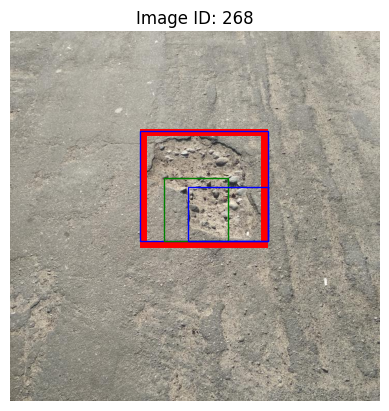

In [ ]:
get_img_detection_visualization(img_detection)